# Ejercicios de índices de sequía

__Índice__<br>

__[1 Datos Spain02](#1-Datos Spain02)__<br>
[1.1 Precipitación](#1.1-Precipitación)<br>
[1.2 Temperatura](#1.2-Temperatura)<br>
[1.3 Evapotranspiración](#1.3-Evapotranspiración)<br>

__[2 Índices de sequía en Santander](#2-Índices-de-sequía-en-Santander)__<br>
[2.1 Extraer datos de Spain02](#2.1-Extraer-datos-de-Spain02)<br>
[2.2 Standard precipitation index: SPI](#2.2-Standard-precipitation-index:-SPI)<br>
[2.3 Standard precipitation-evapotranspiration index: SPEI](#2.3-Standard-precipitation-evapotranspiration-index:-SPEI)<br>
[2.4 Comparación](#2.4-Comparación)<br>

__[3 Índices de sequía en España](#3-Índices-de-sequía-en-España)__<br>
[3.1 Mapas anuales](#3.1-Mapas-anuales)<br>
[3.2 SPI anual](#3.2-SPI-anual)<br>
[3.3 SPEI anual](#3.3-SPEI-anual)<br>
[3.4 Comparación](#3.4-Comparación)<br>

En este ejercicio vamos a calcular dos índices de sequía: el _standard precipitation index_ (SPI) y el _standard precipitation-evapotranspiration index_ (SPEI). Para ello vamos a utilizar la base de datos _Spain02_, que contiene mapas históricos de precipitación y temperatura para toda España.

Como ejercicio inicial, extraeremos de la base de datos las series de precipitación y temperatura correspondientes a Santander y sobre ellos calcularemos los dos índices de sequía. Posteriormente calcularemos el SPI para toda España.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
plt.style.use('seaborn')
%matplotlib inline

from datetime import datetime, timedelta
import scipy.stats as stats
import tqdm

## 1 Datos Spain02
En el ejercicio utilizaremos los mapas mensuales de precipitación y temperatura de la base de datos Spain02. Los datos vienen en formato NetCDF, un formato habitual para trabajar con series temporales de mapas.

In [2]:
from netCDF4 import Dataset
import pickle

### 1.1 Precipitación

In [3]:
# Cargar NetCDF
spain02_pcp = Dataset('Spain02_v5.0_MM_010reg_aa3d_pr.nc', 'r', format='NETCDF4')

In [4]:
# Extraer variables del NetCDF
pcp_m = spain02_pcp.variables['pr'][:]                        # precipitación
lons = spain02_pcp.variables['lon'][:]                        # longitud
lats = spain02_pcp.variables['lat'][:]                        # latitud
cellsize = np.round(np.diff(lons).mean(), 2)                  # calcular resolución espacial
time_m   = spain02_pcp.variables['time'][:]                   # fechas
ref_1950 = datetime(1950, 1, 1).date()                        # fecha de referencia
time_m = [ref_1950 + timedelta(days=i - 14) for i in time_m]  # Convertir 'time_m' en fechas

In [5]:
dimT, dimX, dimY = pcp_m.shape
print('dimensiones de la matriz: ', pcp_m.shape)
print('nº días: {0}\tnº de columnas: {1}\tnº de filas: {2}'.format(len(time_m),
                                                                   len(lats), len(lons)))

dimensiones de la matriz:  (792, 79, 138)
nº días: 792	nº de columnas: 79	nº de filas: 138


### 1.2 Temperatura

In [6]:
# Cargar NetCDF
spain02_tmp = Dataset('Spain02_v5.0_MM_010reg_aa3d_tas.nc', 'r', format='NETCDF4')

# Extraer variables del NetCDF
tmp_m = spain02_tmp.variables['tas'][:]

print('dimensiones de la matriz: ', tmp_m.shape)

dimensiones de la matriz:  (792, 79, 138)


### 1.3 Evapotranspiración
Spain02 no dispone de datos de evapotranspiración. Se calcula la ETP por el método de Thornthwaite, puesto que sólo se dispone de datos de precipitación y temperatura media. El método de Thornthwaite calcula la evapo

In [7]:
# Cargar funciones
%run funciones_sol.ipynb

In [8]:
def etp_thornthwaite(T, lat):
    """Calcula la serie de evapotranspiración potencial mediante el método de
    Thornthwaite:
    
                ETP = 16 * Ld * (10 * T / I)**a [mm]
                
                I = sum(i);     i = (Ti / 5)**1.514
                a = 6.75e-7 * I***3 - 7.71e-5 * I**2 + 1.791e-2 * I + 0.49239
    
    Entradas:
    ---------
    T:       Series. Serie mensual de temperatura media [ºC]
    lat:     float. Latitud del punto de cálculo en grados sexagesimales
    
    Salidas:
    --------
    etp:     Series. Serie mensual de evapotranspiración potencial [mm]"""
    
    # Longitud media del día para cada mes como múltiplo de 12 h
    lat_rad = lat * np.pi / 180
    Ld = _monthly_mean_daylight_hours(latitude_radians=lat_rad, leap=False)
    Ld /= 12
    Ld = pd.Series(Ld, index=range(1, 13))

    # Calcular el índice de calor anual
    I = 0
    Tm = T.groupby(T.index.month).mean()
    for Ti in Tm:
        I += (Ti / 5)**1.514 # índice de calor mensual
        
    # Calcular parámetro 'a'
    a = 6.75e-7 * I**3 - 7.71e-5 * I**2 + 1.791e-2 * I + 0.49239
    
    # Calcular la serie de etp
    etp = pd.Series(index=T.index)
    for idx in etp.index:
        mes = idx.month
        etp[idx] = 16 * Ld[mes] * (10 * T[idx] / I)**a
        
    return etp

In [9]:
calcular_etp = False

if calcular_etp == True: # calcular y exportar mapas mensuales de ETP
    for j, lat in tqdm.tqdm(enumerate(lats)):
        for k, lon in enumerate(lons):
            if etp_m.mask[0,j,k]:
                continue
            lat += cellsize / 2
            pcp = pd.Series(pcp_m.data[:,j,k], index=pd.DatetimeIndex(time_m))
            tmp = pd.Series(tmp_m.data[:,j,k], index=pd.DatetimeIndex(time_m))
            # serie de etp mensual
            etp = etp_thornthwaite(tmp, lat)
            etp[etp > pcp] = pcp[etp > pcp] - 1 # corregir si ETP mayor que precipitación
            etp[etp.isnull()] = 1               # corregir NaN
            etp_m[:,j,k] = etp.values
            del etp
    with open('Spain02_v5.0_MM_010reg_aa3d_etp.pkl', 'wb') as f:
        pickle.dump(etp_m, f)
    
else: # importar mapas mensuales de ETP
    with open('Spain02_v5.0_MM_010reg_aa3d_etp.pkl', 'rb') as f:
        etp_m = pickle.load(f)

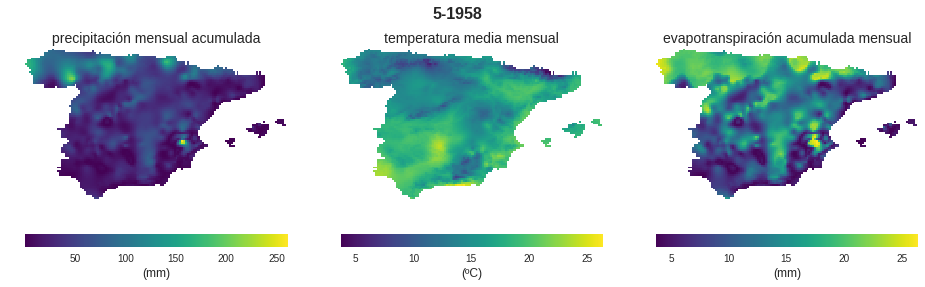

In [11]:
mes = 100

fig, ax = plt.subplots(ncols=3, figsize=(16, 4.25))

# mapa de precipitación
# ---------------------
pcp_map = ax[0].imshow(pcp_m[mes][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[0].axis('off')
ax[0].set_title('precipitación mensual acumulada', fontsize=14)
cb0 = fig.colorbar(pcp_map, ax=ax[0], orientation='horizontal')
cb0.set_label('(mm)', fontsize=12)

# mapa de temperatura
# -------------------
tmp_map = ax[1].imshow(tmp_m[mes][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[1].axis('off')
ax[1].set_title('temperatura media mensual', fontsize=14)
cb1 = fig.colorbar(tmp_map, ax=ax[1], orientation='horizontal')
cb1.set_label('(ºC)', fontsize=12)

# mapa de evapotranspiración
# --------------------------
etp_map = ax[2].imshow(etp_m[mes][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[2].axis('off')
ax[2].set_title('evapotranspiración acumulada mensual', fontsize=14)
cb1 = fig.colorbar(tmp_map, ax=ax[2], orientation='horizontal')
cb1.set_label('(mm)', fontsize=12)

fig.suptitle(str(time_m[mes].month) + '-' + str(time_m[mes].year), fontsize=16,
             fontweight='bold');

## 2 Índices de sequía en Santander

Como introducción al cálculo de los índices de sequía, trabajaremos únicamente con los datos de _Spain02_ para Santander. Es decir, trabajaremos como si tuviéramos las series temporales de una única estación meteorológica.

Analizaremos los índices de sequía tanto a escala mensual como anual, para lo que será necesario agregar a resolución anual los datos mensuales originales.

### 2.1 Extraer datos de Spain02

In [12]:
# coordenadas de Santander
lat_loc, lon_loc = 43.4584300, -3.8071200

# Coordenadas de Sevilla
#lat_loc, lon_loc = 37.3828300, -5.9731700

In [15]:
# posición de Santander en la matriz de Spain02
j_loc = np.argmin(abs(lats + cellsize / 2 - lat_loc))
k_loc = np.argmin(abs(lons + cellsize / 2 - lon_loc))
lat, lon = lats[j_loc] + cellsize / 2, lons[k_loc] + cellsize / 2
print('latitud: {0:.2f} ({1})\tlongitud: {2:.2f} ({3})'.format(lat, j_loc, lon,
                                                               k_loc))

latitud: 43.45 (74)	longitud: -3.85 (54)


#### Precipitación

In [16]:
# extraer serie de precipitación del punto de estudio
pcp_loc_m = pd.Series(data=pcp_m.data[:,j_loc,k_loc], index=pd.DatetimeIndex(time_m))

In [17]:
# calcular la serie anual
pcp_loc_y = pcp_loc_m.resample('Y').sum()
time_y = [idx.year for idx in pcp_loc_y.index]
pcp_loc_y.index = time_y

print('precipitación media anual: {0:.0f} mm'.format(pcp_loc_y.mean()))

precipitación media anual: 1516 mm


#### Temperatura

In [18]:
# extraer serie de temperatura del punto de estudio
tmp_loc_m = pd.Series(data=tmp_m.data[:,j_loc,k_loc],
                      index=pd.DatetimeIndex(time_m))

In [19]:
# calcular la serie anual
tmp_loc_y = tmp_loc_m.resample('Y').mean()
tmp_loc_y.index = time_y

print('temperatura media anual: {0:.0f} ºC'.format(tmp_loc_y.mean()))

temperatura media anual: 14 ºC


#### Evapotranspiración
Para calcular el SPEI es necesaria una serie de evapotranspiración. Como 

In [20]:
# serie de etp mensual
etp_loc_m = etp_thornthwaite(tmp_loc_m, lat)
etp_loc_m[etp_loc_m > pcp_loc_m] = pcp_loc_m[etp_loc_m > pcp_loc_m] - 1 # corregir si ETP mayor que precipitación
etp_loc_m[etp_loc_m.isnull()] = 1                                       # corregir NaN

In [21]:
# calcular la serie anual
etp_loc_y = etp_loc_m.resample('Y').sum()
etp_loc_y.index = [idx.year for idx in etp_loc_y.index]

print('etp media anual: {0:.0f} mm'.format(etp_loc_y.mean()))

etp media anual: 554 mm


#### Gráficas

/home/chuscas/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


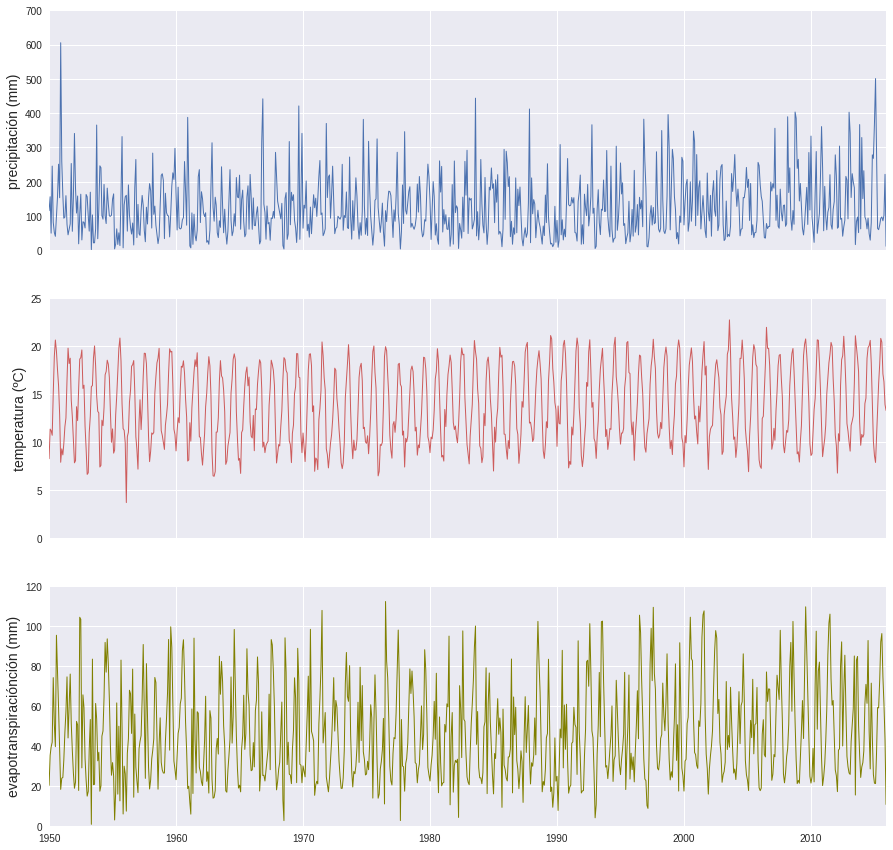

In [22]:
# Gráficas de series mensuales de precipitación, temperatura y evapotranspiración potencial
fig, ax = plt.subplots(nrows=3, figsize=(15, 15), sharex=True)

ax[0].plot(pcp_loc_m, linewidth=1)
ax[0].set_xlim(pcp_loc_m.index[0], pcp_loc_m.index[-1])
ax[0].set_ylim(0, 700)
ax[0].set_ylabel('precipitación (mm)', fontsize=14)

ax[1].plot(tmp_loc_m, color='indianred', linewidth=1)
ax[1].set_ylim(0, 25)
ax[1].set_ylabel('temperatura (ºC)', fontsize=14)

ax[2].plot(etp_loc_m, color='olive', linewidth=1)
ax[2].set_ylim(0, 120)
ax[2].set_ylabel('evapotranspiraciónción (mm)', fontsize=14);

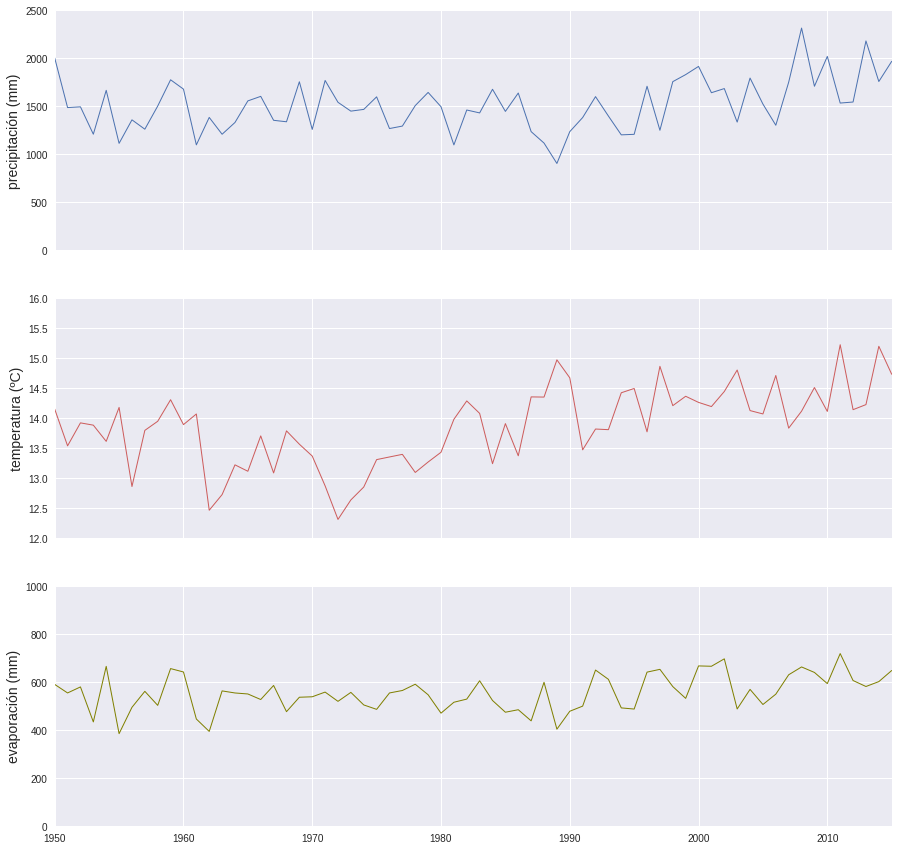

In [23]:
# Gráficas de series anuales de precipitación, temperatura y evapotranspiración potencial
fig, ax = plt.subplots(nrows=3, figsize=(15, 15), sharex=True)

ax[0].plot(pcp_loc_y, linewidth=1)
ax[0].set_xlim(pcp_loc_y.index[0], pcp_loc_y.index[-1])
ax[0].set_ylim(0, 2500)
ax[0].set_ylabel('precipitación (mm)', fontsize=14)

ax[1].plot(tmp_loc_y, color='indianred', linewidth=1)
ax[1].set_ylim(12, 16)
ax[1].set_ylabel('temperatura (ºC)', fontsize=14)

ax[2].plot(etp_loc_y, color='olive', linewidth=1)
ax[2].set_ylim(0, 1000)
ax[2].set_ylabel('evaporación (mm)', fontsize=14);

### 2.2 Standard precipitation index: SPI

El SPI es un índice de sequía basado únicamente en la precipitación, por lo que sólo es capaz de predecir la sequía meteorológica. Una de sus ventajas es que puede calcularse para distintas agregaciones temporales (1-3-6-12-24 meses), con lo que se pueden identificar sequías de diversa duración. Lo calcularemos a resolución anual y mensual.

#### Anual

In [24]:
# ajustar la función de distribución gamma
alpha, loc, beta = stats.gamma.fit(pcp_loc_y, floc=0)
print('alpha = {0:.3f}\tloc = {1:.3f}\tbeta = {2:.3f}'.format(alpha, loc, beta))

alpha = 31.385	loc = 0.000	beta = 48.306


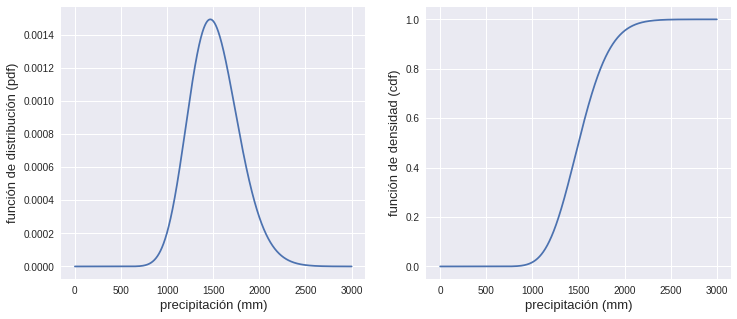

In [25]:
# plotear la función de distribución y de densidad de la gamma ajustada
pcps = np.arange(0, 3000, 0.1)
pdf_gamma = stats.gamma.pdf(pcps, alpha, loc, scale=beta)
cdf_gamma = stats.gamma.cdf(pcps, alpha, loc, scale=beta)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)

# función de distribución
ax[0].plot(pcps, pdf_gamma)
#ax[0].set(xlim=(0, 10), ylim=(0, 1.2))
ax[0].set_xlabel('precipitación (mm)', fontsize=13)
ax[0].set_ylabel('función de distribución (pdf)', fontsize=13)

# función de densidad
ax[1].plot(pcps, cdf_gamma)
#ax[1].set(ylim=(0, 1))
ax[1].set_xlabel('precipitación (mm)', fontsize=13)
ax[1].set_ylabel('función de densidad (cdf)', fontsize=13);

Seguidamente se calcula, a modo de ejemplo, el SPI para un año aleatorio (en este caso el dato 11 de la serie anual). En el gráfico más abajo se explica de manera visual cuál es el procedimiento. Se calcula la probabilidad de no excendencia del dato de la serie según la distribución gamma; para dicho valor de probabilidad, se extrae de la normal el valor que generaría dicha probabilidad; dicho valor es el SPI.

In [26]:
# Calcular el SPI de un año concreto
pcp = pcp_loc_y.iloc[10]
cdf = stats.gamma.cdf(pcp, alpha, loc, beta)

SPI = stats.norm.ppf(cdf)
print('pcp = {0:.2f} mm/d \tcdf = {1:.3f}\tSPI = {2:.3f}'.format(pcp, cdf, SPI))

pcp = 1679.35 mm/d 	cdf = 0.740	SPI = 0.642


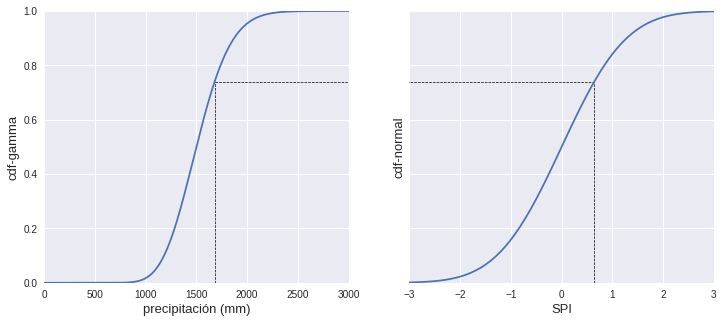

In [27]:
# plotear el método de cálculo
spis = np.arange(-5, 5, 0.1)
cdf_norm = stats.norm.cdf(spis, loc=0, scale=1)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

# función de densidad gamma
ax[0].plot(pcps, cdf_gamma)
ax[0].vlines(pcp, 0, cdf, linestyle='--', linewidth=0.7)
ax[0].hlines(cdf, pcp, 3000, linestyle='--', linewidth=0.7)
ax[0].set(xlim=(0, 3000), ylim=(0, 1))
ax[0].set_xlabel('precipitación (mm)', fontsize=13)
ax[0].set_ylabel('cdf-gamma', fontsize=13)

# función de densidad normal
ax[1].plot(spis, cdf_norm)
ax[1].hlines(cdf, -10, SPI, linestyle='--', linewidth=0.7)
ax[1].vlines(SPI, 0, cdf, linestyle='--', linewidth=0.7)
ax[1].set(xlim=(-3, 3), ylim=(0, 1))
ax[1].set_xlabel('SPI', fontsize=13)
ax[1].set_ylabel('cdf-normal', fontsize=13);

De cara a falicitar el código en los posteriores cálculos, crearemos una función que englobe todos los pasos necesarios para calcular el SPI. También definiremos una función para crear un gráfico con la serie temporal del SPI en el que se vean los distintos rangos y su definición.

In [28]:
def SPI(serie_pcp, verbose=False):
    """Calcular el 'standard precipitation index' (SPI) de una serie de
    precipitación
    
    Entradas:
    ---------
    serie_pcp: Series. Serie de precipitación
    verbose:   boolean. Si se muestran los coeficientes ajustados para la
               distribución gamma
    
    Salidas:
    --------
    SPIs:      Series. Serie de SPI
    """
    
    # ajustar la función de distribución gamma
    alpha, loc, beta = stats.gamma.fit(serie_pcp, floc=0)
    if verbose == True:
        print('alpha = {0:.3f}\tloc = {1:.3f}\tbeta = {2:.3f}'.format(alpha, loc,
                                                                      beta))
    
    # calcular el SPI para la serie
    SPIs = pd.Series(index=serie_pcp.index)
    for idx, pcp in zip(serie_pcp.index, serie_pcp):
        cdf = stats.gamma.cdf(pcp, alpha, loc, beta)
        SPIs[idx] = stats.norm.ppf(cdf)
        
    return SPIs

In [29]:
def plot_SPI(serie_spi, title):
    """Crea un diagrama de línea con la evolución temporal del SPI
    
    Entradas:
    ---------
    serie_spi: Series. Serie temporal de SPI
    title:     string. Título del gráfico
    
    Salidas:
    --------
    Gráfico de línea"""
    
    # Configuración
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set(xlim=(serie_spi.index[0], serie_spi.index[-1]), ylim=(-3, 3))
    ax.set_title(title, fontsize=14)
    
    # Gráfico de línea del SPI
    ax.plot(serie_spi, color='k', linewidth=1.2)
    
    # Fondo con la leyenda de cada rango de SPI
    ax.fill_between(serie_spi.index, -3, -2, color='indianred', alpha=0.4,
                    label='sequía extrema')
    ax.fill_between(serie_spi.index, -2, -1.5, color='indianred', alpha=0.3,
                    label='sequía severa')
    ax.fill_between(serie_spi.index, -1.5, -1, color='indianred', alpha=0.2,
                    label='sequía moderada')
    ax.fill_between(serie_spi.index, -1, 0, color='indianred', alpha=0.1,
                    label='sequía ligera')
    ax.fill_between(serie_spi.index, 0, 1, color='steelblue', alpha=0.1,
                    label='húmedo ligero')
    ax.fill_between(serie_spi.index, 1, 1.5, color='steelblue', alpha=0.2,
                    label='húmedo moderado')
    ax.fill_between(serie_spi.index, 1.5, 2, color='steelblue', alpha=0.3,
                    label='húmedo severo')
    ax.fill_between(serie_spi.index, 2, 3, color='steelblue', alpha=0.4,
                    label='húmedo extremo')
    
    # leyenda
    fig.legend(loc=[0.15, 0], ncol=4, fontsize=11);

In [30]:
# calcular SPI de la serie anual
SPIy_loc = SPI(pcp_loc_y)

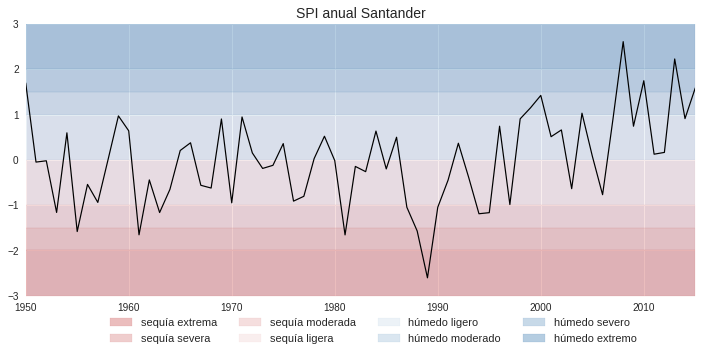

In [31]:
# gráfico del SPI anual
plot_SPI(SPIy_loc, title='SPI anual Santander')

#### Mensual

In [32]:
# Serie mensual de SPI en el punto de cálculo
SPIm_loc = pd.Series(index=pcp_loc_m.index)

for mes in np.arange(1, 13):
    mask = pcp_loc_m.index.month == mes
    aux = pcp_loc_m[mask]
    SPIm_loc[aux.index] = SPI(aux)
    del aux, mask

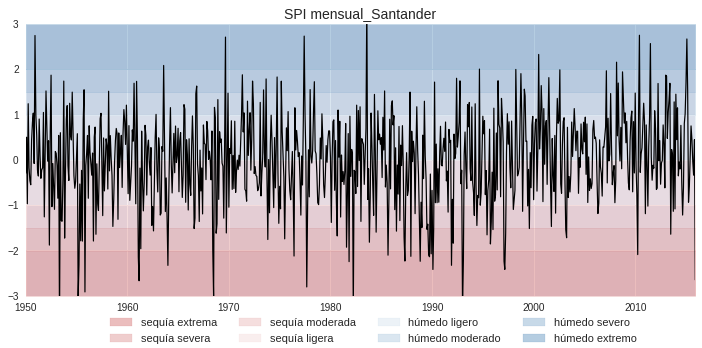

In [33]:
# Gráfico de la evolución temporal del SPI en el punto de cálculo
plot_SPI(SPIm_loc, 'SPI mensual Santander')

### 2.3 Standard precipitation-evapotranspiration index: SPEI
El SPEI es un índice derivado del SPI en el que se incluye la evapotranspiración para crear un índice de sequía hidrológica al añadir más variables del ciclo hidrológico. La única diferencia con respecto al SPI es que la serie temporal de entrada no es la precipitación, sino la diferencia entre precipitación y evapotranspiración.

Al igual que el SPI, permite analizar diversas agregaciones temporales, con lo que se pueden identificar sequías de diversa duración. De nuevo analizaremos la escala anual y mensual.
#### Anual

In [34]:
# variable a la que se aplica el SPEI: diferencia de precipitación y evapotranspiración
dif_loc_y = pcp_loc_y - etp_loc_y

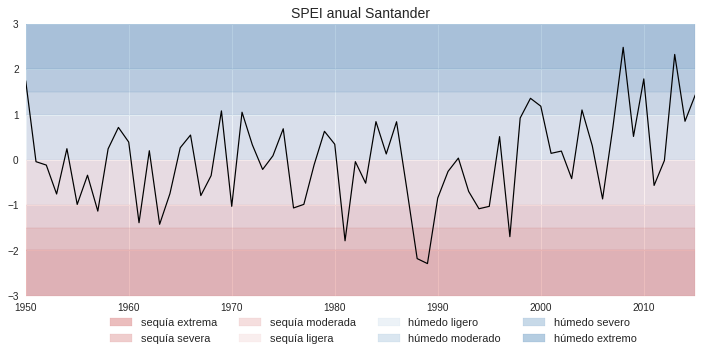

In [35]:
# Serie anual de SPEI en el punto de cálculo
SPEIy_loc = SPI(dif_loc_y)

# Gráfico de la evolución temporal del SPEI en el punto de cálculo
plot_SPI(SPEIy_loc, 'SPEI anual Santander')

#### Mensual

In [36]:
# variable a la que se aplica el SPEI: diferencia de preciptiación y evapotranspiración (D)
dif_loc_m = pcp_loc_m - etp_loc_m

In [37]:
# Serie mensual de SPEI en el punto de cálculo
SPEIm_loc = pd.Series(index=pcp_loc_m.index)

for mes in np.arange(1, 13):
    mask = dif_loc_m.index.month == mes
    aux = dif_loc_m[mask]
    SPEIm_loc[aux.index] = SPI(aux)
    del aux, mask

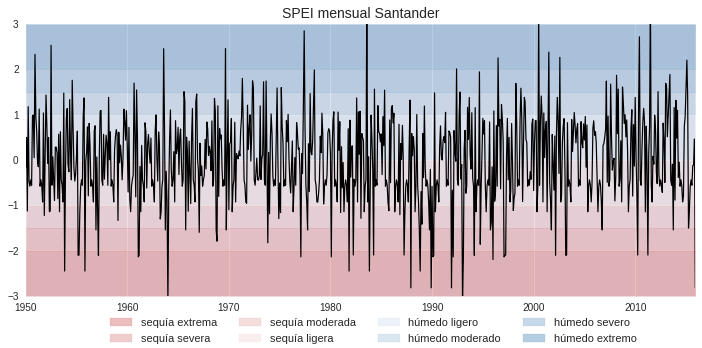

In [38]:
# Gráfico de la evolución temporal del SPEI en el punto de cálculo
plot_SPI(SPEIm_loc, 'SPEI mensual Santander')

### 2.4 Comparación

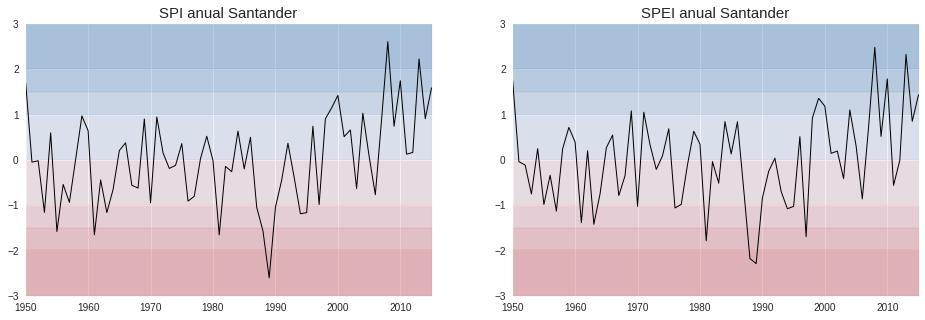

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

for i in np.arange(0, 2):
    r, c = int(i / 2), i % 2
    if i == 0:
        serie = SPIy_loc
        title = 'SPI anual Santander'
    elif i == 1:
        serie = SPEIy_loc
        title = 'SPEI anual Santander'
    
    # Evolución temporal del SPI/SPEI
    axes[i].plot(serie, color='k', linewidth=1)
    
    # Fondos con los rangos de SPI/SPEI
    axes[i].fill_between(serie.index, -3, -2, color='indianred', alpha=0.4,
                     label='sequía extrema')
    axes[i].fill_between(serie.index, -2, -1.5, color='indianred', alpha=0.3,
                     label='sequía severa')
    axes[i].fill_between(serie.index, -1.5, -1, color='indianred', alpha=0.2,
                     label='sequía moderada')
    axes[i].fill_between(serie.index, -1, 0, color='indianred', alpha=0.1,
                     label='sequía ligera')
    axes[i].fill_between(serie.index, 0, 1, color='steelblue', alpha=0.1,
                     label='húmedo ligero')
    axes[i].fill_between(serie.index, 1, 1.5, color='steelblue', alpha=0.2,
                     label='húmedo moderado')
    axes[i].fill_between(serie.index, 1.5, 2, color='steelblue', alpha=0.3,
                     label='húmedo severo')
    axes[i].fill_between(serie.index, 2, 3, color='steelblue', alpha=0.4,
                     label='húmedo extremo')
    axes[i].set(xlim=(serie.index[0], serie.index[-1]), ylim=(-3, 3))
    axes[i].set_title(title, fontsize=15)

In [40]:
# Años de sequía según SPI
sequia_SPI = SPIy_loc[SPIy_loc < -1].index
print('nº sequias según SPI: {0}'.format(len(sequia_SPI)))
print(sequia_SPI.values)
print()

# Años de sequía según SPEI
sequia_SPEI = SPEIy_loc[SPEIy_loc < -1].index
print('nº sequias según SPI: {0}'.format(len(sequia_SPEI)))
print(sequia_SPEI.values)

nº sequias según SPI: 11
[1953 1955 1961 1963 1981 1987 1988 1989 1990 1994 1995]

nº sequias según SPI: 11
[1957 1961 1963 1970 1976 1981 1988 1989 1994 1995 1997]


Se entiende como sequía todo valor por debajo de *-1*. Según esto, __tanto el SPI como el SPEI identifican 11 sequías__ a escala anual.

Sin embargo, __los índices no identifican los mismos años de sequía__. El SPI encuentra como secos los años 1953, 1955, 1987 y 1990, para los que no hubo sequía según el SPEI. Por el contrario, el SPEI define como secos los años 1957, 1970, 1976 y 1997, para los que no hubo sequía según el SPI. La diferencia es debida a que el SPI es un indicador de la sequía meteorológica, mientras que el SPEI lo es para la sequía hidrológica. De este modo, el SPI identifica como secos años aquellos con precipitación por debajo de lo normal, sin importar si en dicho año la temperatura causó una mayor o menor evaporación y, por tanto, precipitación neta. En cambio el SPEI puede identificar como secos años con una precipitación normal si la evapotranspiración es alta, o como años sin sequía aquéllos con poca precipitación si la evapotranspiración también es baja.

Existen otros índices de sequía como el PDSI (_Palmer drought severity index_). Es uno de los índices más comúnmente usados, pero tiene el inconveniente de sólo poder ser usado a escala anual.

En general, los índices deben ser acordes al criterio de sequía de estudio. Por ejemplo, el SPI es un índice adecuado si el objeto de nuestro estudio es la sequía meteorológica; sin embargo, si nos interesa la sequía agrícola es necesario utilizar índices que incluyan otras variables como la humedad del suelo o factores económicos.

## 3 Índices de sequía en España

Entendido el cálculo para una serie temporal, calcular los índices de sequía para toda España consiste en iterar el proceso a través de todas las celdas del mapa. Calcularemos de nuevo el SPI y SPEI a resolución anual y mensual. Puesto que no tenemos mapas anuales, es necesario agregar los mapas mensuales.
### 3.1 Mapas anuales

In [41]:
# 'array' 3D donde calcular mapas anuales de precipitación
pcp_y = pcp_m[:int(dimT / 12),:,:].copy()
pcp_y.data[:,:,:] = np.nan

In [42]:
# 'array' 3D donde calcular mapas anuales de temperatura
tmp_y = tmp_m[:int(dimT / 12),:,:].copy()
tmp_y.data[:,:,:] = np.nan

In [43]:
# 'array' 3D donde calcular mapas anuales de temperatura
etp_y = etp_m[:int(dimT / 12),:,:].copy()
etp_y.data[:,:,:] = np.nan

In [44]:
# Calcular mapas mensuales
for i in range(len(time_y)):
    st, en = i * 12, (i + 1) * 12
    # precipitación anual acumulada
    pcp_y[i,:,:] = pcp_m[st:en, :, :].sum(axis=0)
    # temperatura media anual
    tmp_y[i,:,:] = tmp_m[st:en, :, :].mean(axis=0)
    # evapotranspiración media anual
    etp_y[i,:,:] = etp_m[st:en, :, :].sum(axis=0)

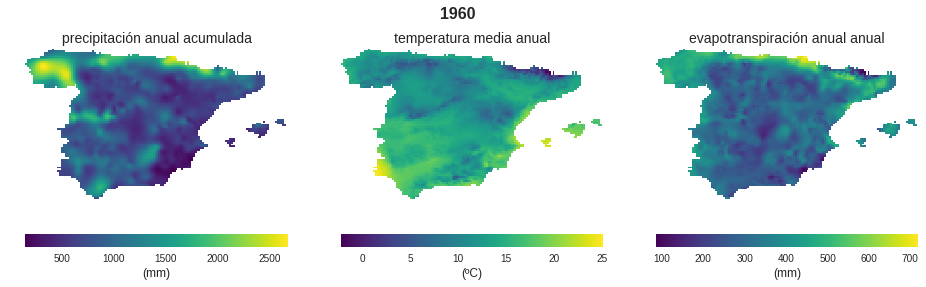

In [45]:
year = 10

fig, ax = plt.subplots(ncols=3, figsize=(16, 4.25))

# mapa de precipitación
# ---------------------
pcp_map = ax[0].imshow(pcp_y[year][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[0].axis('off')
ax[0].set_title('precipitación anual acumulada', fontsize=14)
cb0 = fig.colorbar(pcp_map, ax=ax[0], orientation='horizontal')
cb0.set_label('(mm)', fontsize=12)

# mapa de temperatura
# -------------------
tmp_map = ax[1].imshow(tmp_y[year][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[1].axis('off')
ax[1].set_title('temperatura media anual', fontsize=14)
cb1 = fig.colorbar(tmp_map, ax=ax[1], orientation='horizontal')
cb1.set_label('(ºC)', fontsize=12)

# mapa de evapotranspiración
# --------------------------
etp_map = ax[2].imshow(etp_y[year][::-1], cmap='viridis', aspect='equal')
# configurar la figura
ax[2].axis('off')
ax[2].set_title('evapotranspiración anual anual', fontsize=14)
cb2 = fig.colorbar(etp_map, ax=ax[2], orientation='horizontal')
cb2.set_label('(mm)', fontsize=12)

fig.suptitle(time_y[year], fontsize=16, fontweight='bold');

### 3.2 SPI anual

In [46]:
# SPI anual para toda España
SPIy_es = pcp_y[:,:,:].copy()
SPIy_es.data[:,:,:] = np.nan

for x in tqdm.tqdm(range(dimX)):
    for y in range(dimY):
        if SPIy_es.mask[0][x, y]:
            continue
        aux = pd.Series(pcp_y[:,x,y].data, index=pd.DatetimeIndex(time_y))
        SPIy_es[:,x,y] = SPI(aux).values

100%|██████████| 79/79 [02:38<00:00,  2.01s/it]


###  3.3 SPEI anual

In [47]:
# SPEI anual para toda España
SPEIy_es = pcp_y[:,:,:].copy()
SPEIy_es.data[:,:,:] = np.nan

for x in tqdm.tqdm(range(dimX)):
    for y in range(dimY):
        if SPEIy_es.mask[0][x, y]:
            continue
        dif_y = pcp_y[:,x,y].data - etp_y[:,x,y].data
        aux = pd.Series(dif_y, index=pd.DatetimeIndex(time_y))
        SPEIy_es[:,x,y] = SPI(aux).values

100%|██████████| 79/79 [02:37<00:00,  1.99s/it]


### 3.4 Comparación

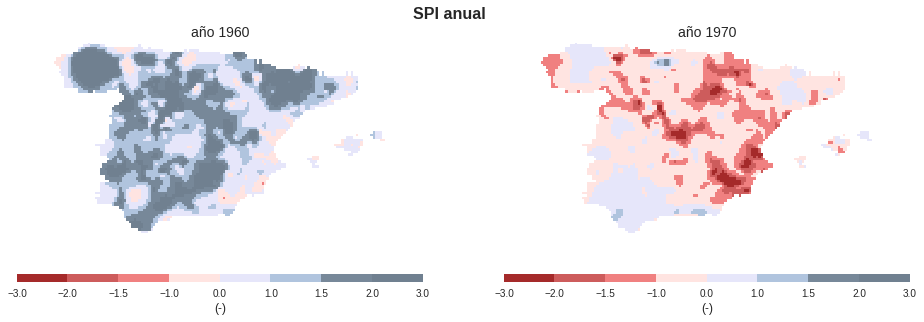

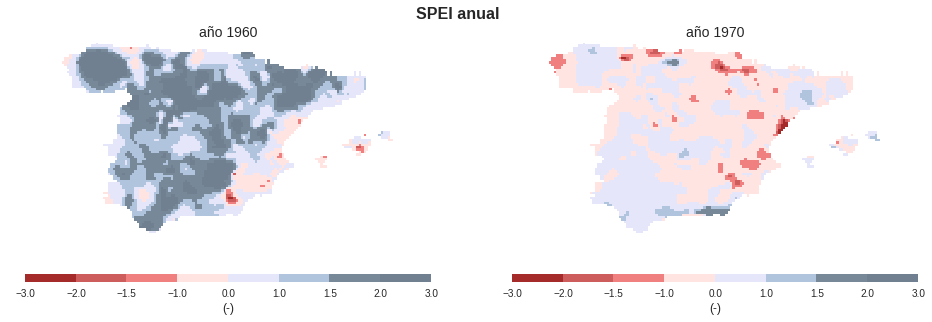

In [48]:
year1, year2 = 10, 20

# Configurar escala
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['brown', 'indianred', 'lightcoral', 'mistyrose',
                                  'lavender', 'lightsteelblue', 'lightslategray',
                                  'slategray'])
boundaries = [-3.0, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.0]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

# FIGURA 1: SPI
###############
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# SPI año 1
# ---------
map1 = ax[0].imshow(SPIy_es[year1][::-1], cmap=cmap, norm=norm, aspect='equal')
# configurar la figura
ax[0].axis('off')
ax[0].set_title('año ' + str(time_y[year1]), fontsize=14)
cb1 = fig.colorbar(map1, ax=ax[0], orientation='horizontal', aspect=50)
cb1.set_label('(-)', fontsize=12)

# SPI año 2
# ---------
map2 = ax[1].imshow(SPIy_es[year2][::-1], cmap=cmap, norm=norm, aspect='equal')
# configurar la figura
ax[1].axis('off')
ax[1].set_title('año ' + str(time_y[year2]), fontsize=14)
cb2 = fig.colorbar(map2, ax=ax[1], orientation='horizontal', aspect=50)
cb2.set_label('(-)', fontsize=12)

fig.suptitle('SPI anual', fontsize=16, fontweight='bold');

# FIGURA 2: SPEI
################
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# SPEI año 1
# ---------
map1 = ax[0].imshow(SPEIy_es[year1][::-1], cmap=cmap, norm=norm)
# configurar la figura
ax[0].axis('equal')
ax[0].axis('off')
ax[0].set_title('año ' + str(time_y[year1]), fontsize=14)
cb1 = fig.colorbar(map1, ax=ax[0], orientation='horizontal', aspect=50)
cb1.set_label('(-)', fontsize=12)

# SPEI año 2
# ---------
map2 = ax[1].imshow(SPEIy_es[year2][::-1], cmap=cmap, norm=norm)
# configurar la figura
ax[1].axis('equal')
ax[1].axis('off')
ax[1].set_title('año ' + str(time_y[year2]), fontsize=14)
cb2 = fig.colorbar(map2, ax=ax[1], orientation='horizontal', aspect=50)
cb2.set_label('(-)', fontsize=12)

fig.suptitle('SPEI anual', fontsize=16, fontweight='bold');

Los dos mapas muestran dos años con un régimen hidrológico muy distinto. El año 1960 fue un año húmedo en gran parte de España, con la excepción de la costa mediterránea. El año 1970 fue un año seco en la mitad Este del país y zonas aisladas del Cantábrico. 

De nuevo se observan diferencias entre el SPI y el SPEI. Mientras que los mapas de SPI y SPEI para el año 1960 son muy parecidos, los del SPEI difieren sensiblemente, siendo las zonas afectadas por la sequía mucho más reducidas.